# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('raw_data.csv')
df.head()

,entrada,llegada_pico,salida,tiempo_cola,tiempo_servicio,tiempo_total
0,07:24:48,07:36:53,07:43:21,725,388,1113
1,07:25:06,07:43:21,07:45:42,1095,141,1236
2,07:24:17,07:41:38,07:43:01,1041,83,1124
3,07:34:50,07:46:48,07:48:26,718,98,816
4,07:36:21,07:48:26,07:52:25,725,239,964


In [3]:
df.describe()

,tiempo_cola,tiempo_servicio,tiempo_total
count,33.000000,33.000000,33.000000
mean,753.272727,209.030303,962.303030
std,360.634447,114.568343,358.024483
min,160.000000,37.000000,393.000000
25%,527.000000,120.000000,780.000000
50%,718.000000,185.000000,908.000000
75%,934.000000,283.000000,1124.000000
max,1656.000000,430.000000,1956.000000


In [4]:
def to_datetime_or_na(series):
    return pd.to_datetime(series, format='%H:%M:%S', errors='coerce')

df_final = df.copy()

df_final['entrada_dt'] = to_datetime_or_na(df_final['entrada'])
df_final['llegada_pico_dt'] = to_datetime_or_na(df_final['llegada_pico'])
df_final['salida_dt'] = to_datetime_or_na(df_final['salida'])

# Sort by entrada_dt
df_final = df_final.sort_values(by='entrada_dt').reset_index(drop=True)

In [5]:
def calculate_time_minutes(df, start_col, end_col):
    return (df[end_col] - df[start_col]).dt.total_seconds() / 60


df_final['Tiempo_Cola_min'] = calculate_time_minutes(df_final, 'entrada_dt', 'llegada_pico_dt')
df_final['Tiempo_Servicio_min'] = calculate_time_minutes(df_final, 'llegada_pico_dt', 'salida_dt')
df_final['Tiempo_Total_Sistema_min'] = calculate_time_minutes(df_final, 'entrada_dt', 'salida_dt')
df_final['Tiempo_Entre_Llegada_min'] = df_final['entrada_dt'].diff().dt.total_seconds() / 60

df_final = df_final.drop(columns=['entrada', 'llegada_pico', 'salida', 'tiempo_total', 'tiempo_cola', 'tiempo_servicio'])

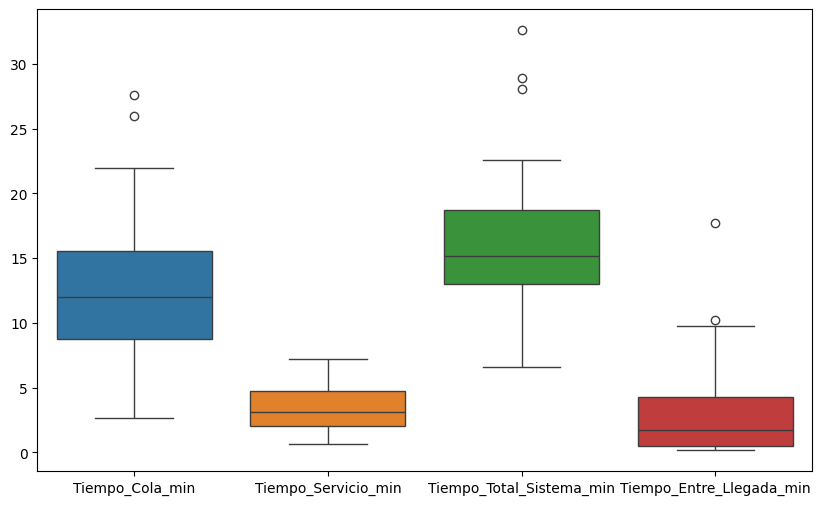

In [6]:
# Box plot to identify outliers
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final[['Tiempo_Cola_min', 'Tiempo_Servicio_min', 'Tiempo_Total_Sistema_min', 'Tiempo_Entre_Llegada_min']])
plt.show()

In [7]:
def detect_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    print(f'Number of outliers in {column_name}: {outliers.shape[0]}')

    return outliers

detect_outliers_iqr(df_final, 'Tiempo_Cola_min')
detect_outliers_iqr(df_final, 'Tiempo_Total_Sistema_min')
outliers = detect_outliers_iqr(df_final, 'Tiempo_Servicio_min')
outliers

Number of outliers in Tiempo_Cola_min: 2
Number of outliers in Tiempo_Total_Sistema_min: 3
Number of outliers in Tiempo_Servicio_min: 0


,entrada_dt,llegada_pico_dt,salida_dt,Tiempo_Cola_min,Tiempo_Servicio_min,Tiempo_Total_Sistema_min,Tiempo_Entre_Llegada_min


In [8]:
df_final = df_final.drop(outliers.index)
df_final = df_final.reset_index(drop=True)
df_final = df_final[[col for col in df_final.columns if not col.endswith('_dt')]]
df_final.describe()

,Tiempo_Cola_min,Tiempo_Servicio_min,Tiempo_Total_Sistema_min,Tiempo_Entre_Llegada_min
count,33.000000,33.000000,33.000000,32.000000
mean,12.554545,3.483838,16.038384,3.076563
std,6.010574,1.909472,5.967075,3.905735
min,2.666667,0.616667,6.550000,0.166667
25%,8.783333,2.000000,13.000000,0.487500
50%,11.966667,3.083333,15.133333,1.691667
75%,15.566667,4.716667,18.733333,4.279167
max,27.600000,7.166667,32.600000,17.733333


In [9]:
df_final.to_csv('processed_data.csv', index=False)